In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


Using device: cuda
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 0, 8, 4, 8, 1, 7, 7])
y type: torch.int64


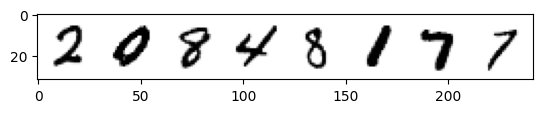

In [2]:
from tqdm.auto import tqdm
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# 载入MNIST数据集
dataset = torchvision.datasets.MNIST(root="mnist/", train=True,
                                     download=True, transform=torchvision.transforms.ToTensor())

# 创建数据加载器
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 查看MNIST数据集中的部分样本
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
print('y type:', y.dtype)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')


In [7]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # 网络会将数字所属的类别映射到一个长度为class_emb_size的特征向量上
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # self.model 是一个不带生成条件的UNet模型，在这里，我们
        # 添加额外的输入通道，用于接收条件信息（类别特征向量）
        self.model = UNet2DModel(
            sample_size=28,
            in_channels=1 + class_emb_size,

            out_channels=1,
            layers_per_block=2,
            block_out_channels=(32, 64, 64),

            down_block_types=(
                "DownBlock2D",
                "AttnDownBlock2D",
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
            ),
        )

    def forward(self, x, t, class_labels):
        
        bs, ch, w, h = x.shape

        # 类别条件会以额外通道形式输入
        class_cond = self.class_emb(class_labels)
        # 将类别映射为向量形式，并扩展成类似于(bs, 4, 28, 28)的张量形状
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # 将原始输入和类别条件信息拼接到一起
        # x:(bs, 1, 28, 28) class_cond:(bs, 4, 28, 28)
        # net_input:(bs, 5, 28, 28)
        net_input = torch.cat((x, class_cond), 1)   
        
        # 使用模型进行预测
        return self.model(net_input, t).sample


net = ClassConditionedUnet()
print(net)

ClassConditionedUnet(
  (class_emb): Embedding(10, 4)
  (model): UNet2DModel(
    (conv_in): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): LoRACompatibleLinear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): LoRACompatibleLinear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): LoRACompatibleLinear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): LoRACompatibleConv(32, 32, kernel_size=(3, 3), stride=(1, 1),

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.052720


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.046396


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.043604


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.042078


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.040819


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.040701


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.040053


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039902


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.039026


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.038354


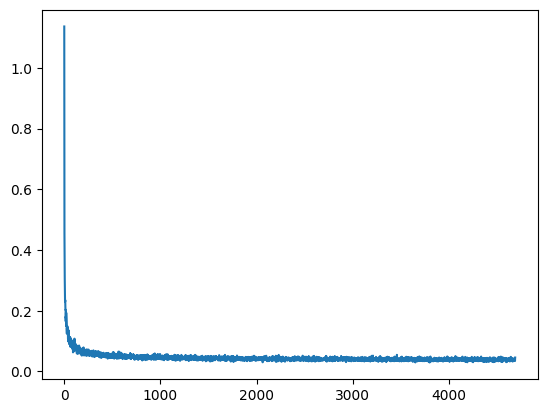

In [10]:

noise_scheduler = DDPMScheduler(num_train_timesteps=1000,
                                beta_schedule="squaredcos_cap_v2")

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
n_epochs = 10

net = ClassConditionedUnet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

# 训练模型
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # 获取数据并添加噪声
        x = x.to(device)*2-1    # 将数据归一化到[-1, 1]范围内
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        # print("timesteps shape:", timesteps.shape)

        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        pred = net(noisy_x, timesteps, y)
        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)
plt.show()

x shape: torch.Size([80, 1, 28, 28])
y shape: torch.Size([80])


0it [00:00, ?it/s]

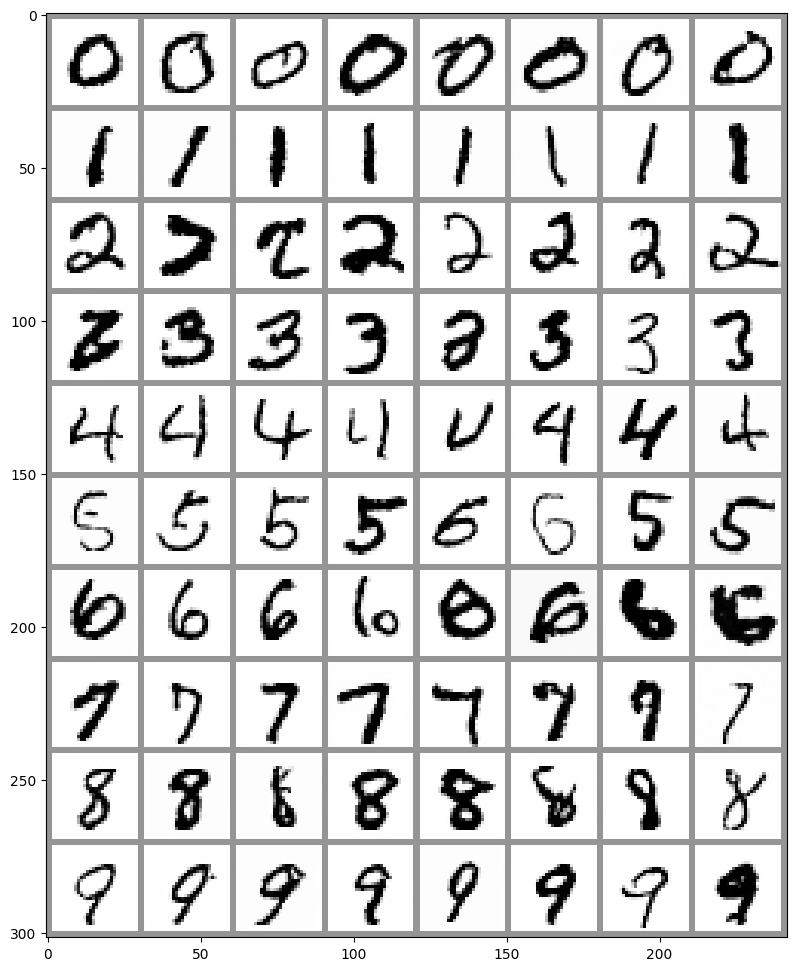

In [11]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
print("x shape:", x.shape)
print("y shape:", y.shape)

for i, t in tqdm(enumerate(noise_scheduler.timesteps), len(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)
    x = noise_scheduler.step(residual, t, x).prev_sample

# 查看结果
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0],cmap='Greys')
